### List of Libraries

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.parametrizations import spectral_norm
import random

### Hyper Parameters

In [26]:
BATCH_SIZE = 64
HIDDEN_FEATURES = 32
LR = 1e-4
ALPHA = 0.001
BETA1 = 0.0
NUM_EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading Dataset

We perform a linear transformation to scale the pixel values to a range of **[-1, 1]**

* **Mean ():** 0.5
* **Standard Deviation ():** 0.5

When we use `transforms.ToTensor()`, our image pixels (originally 0 to 255) are converted into floating-point numbers between **0 and 1**.

When `Normalize((0.5,), (0.5,))` is applied:

* **Minimum value (0):** 
* **Maximum value (1):** 
* **Middle value (0.5):** 

---

### Why do we do this?

* **Faster Convergence:** Neural networks generally learn faster when the input data has a mean of 0 and a similar scale. It prevents the gradients from oscillating wildly during backpropagation.
* **Activation Function Alignment:** The activation function used in this architecture is centered at 0. Scaling the data to  ensures that the input signal sits in the most "active" parts of these functions.


In [27]:
def get_dataloaders(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform
    )
    
    test_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform
    )

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


train_loader, test_loader = get_dataloaders(batch_size=BATCH_SIZE)


### Shape and Scale of Each Image

#### each image is repreasented with a tensor with dimensions of (1,28,28) and is scaled between [0,1], an example is provided below

In [28]:
for batch in train_loader:
    images, _ = batch
    image = images[0]
    print(image.shape)
    print(f"image min is {image.min()}")
    print(f"image max is {image.max()}")
    break

torch.Size([1, 28, 28])
image min is -1.0
image max is 1.0


### Visualizing Dataset

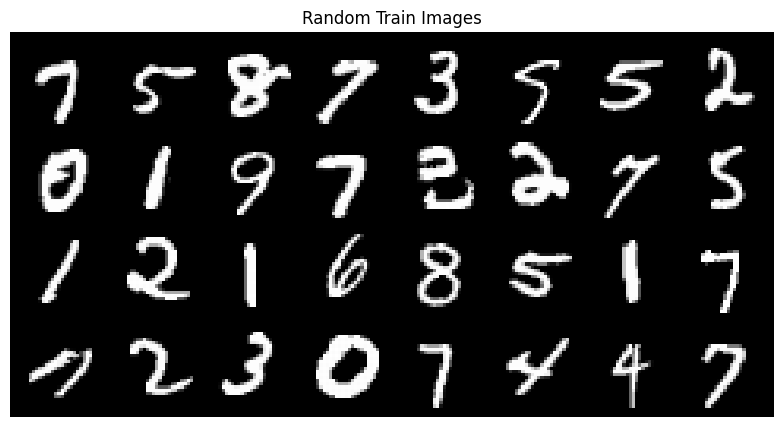

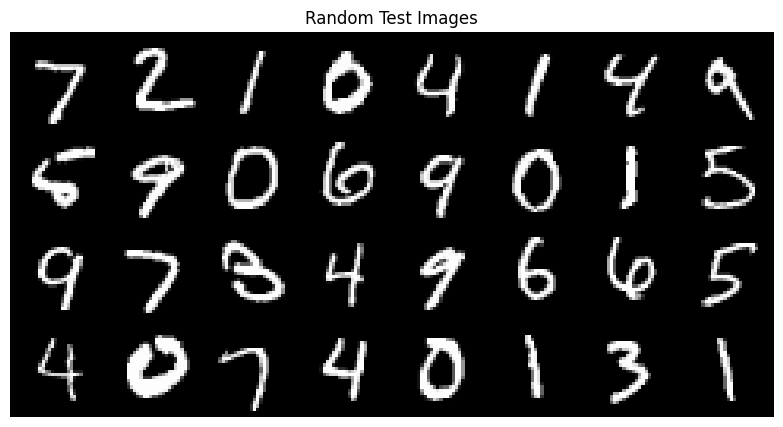

In [29]:
def show_batch_images(dataloader, title, num_images):
    for batch in dataloader:
        images, _ = batch
        images = images[:num_images]
        break
    
    grid_img = torchvision.utils.make_grid(images, nrow=8, padding=2, normalize=True)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

show_batch_images(train_loader, "Random Train Images", 32)

show_batch_images(test_loader, "Random Test Images", 32)

### Model Architecture

A Simple CNN was used but with few changes:


## 1. **Spectral Normalization (SN)**

In an EBM, the model is a scalar function . Training involves pushing the energy **down** for real images and **up** for fake (sampled) images. Without constraints, the model can "cheat" by making the energy values infinitely large or small to satisfy the loss function. This leads to **exploding gradients**, where the energy surface becomes so steep and jagged that the MCMC sampler (Langevin Dynamics) fails.

Spectral Normalization is a technique used to ensure a neural network is **Lipschitz continuous**.

A function is -Lipschitz if the rate at which the output changes is bounded by a constant, This prevents the energy surface from having sharp, vertical cliffs.

The "Lipschitz constant" of a linear layer (or convolution) is equal to its **Spectral Norm** (the largest singular value of its weight matrix ).

Spectral Normalization works by dividing every weight in a layer by its spectral norm :


This forces the spectral norm of the layer to be exactly **1**. By keeping the spectral norm of every layer small, the gradient of the entire network stays "under control."

### Why?

EBMs use **Langevin Dynamics** to generate images. This process updates a noise image  using the gradient of the energy:


* **Without SN:** The gradient  can be massive. The "step" in Langevin dynamics becomes huge, and the image turns into static/garbage instantly.
* **With SN:** The gradient is bounded. The "steps" we take during sampling are stable, allowing the noise to gradually morph into a recognizable MNIST digit.

---

## 2. **Swish Activation Function**

Swish Activation(SiLU): 



EBMs rely on Langevin Dynamics (MCMC) during training, which involves taking the gradient of the energy with respect to the input image ($\nabla_x E(x)$).LeakyReLU (in your first model) has a "kink" at zero where the derivative is discontinuous. This can lead to "stuck" particles during MCMC sampling.Swish is smooth and continuously differentiable, which leads to much more stable and higher-quality image generation.


The Swish activation function (also known as **SiLU** or Sigmoid Linear Unit) has become a favorite in the deep learning community, particularly for models like EBMs that rely on high-quality gradients.

### 1. The Formula

The Swish function is defined as:

Where  is the sigmoid function:

#### f(x) = x . sigmoid(beta . x)
    
### 2. Advantages of Swish

* **Smoothness (Differentiability):** Unlike ReLU, which has a sharp "corner" (discontinuity) at , Swish is smooth everywhere. For an EBM, this is its most important feature because the **Langevin sampling** process uses the gradient of the energy. A smooth function ensures the gradient doesn't suddenly "jump" or disappear.
* **Non-Monotonicity:** Swish actually "dips" slightly below zero for small negative inputs before returning to zero. This allows the model to retain some information from negative inputs, which can help with gradient flow.
* **No "Dying ReLU" Problem:** Because it doesn't output a hard zero for all negative values, it is less likely for neurons to "die" (stop updating) during training compared to standard ReLU.
---


### images: 28*28 -> 14x14 (Downsample) -> 14x14 (Refine) -> 7x7 (Downsample) -> 7x7 (Refine) -> Flattern

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import spectral_norm

class EnergyModel(nn.Module):
    def __init__(self, hidden_features=32):
        super().__init__()
        
        def sn_conv(in_c, out_c, k, s, p):
            return spectral_norm(nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p))

        self.network = nn.Sequential(
            sn_conv(1, hidden_features, 3, 1, 1),
            nn.SiLU(),
            
            sn_conv(hidden_features, hidden_features, 4, 2, 1),
            nn.SiLU(),
            
            sn_conv(hidden_features, hidden_features * 2, 3, 1, 1),
            nn.SiLU(),
            
            sn_conv(hidden_features * 2, hidden_features * 2, 4, 2, 1),
            nn.SiLU(),
            
            sn_conv(hidden_features * 2, hidden_features * 4, 3, 1, 1),
            nn.SiLU(),
            
            nn.Flatten(),
            nn.Linear(hidden_features * 4 * 7 * 7, hidden_features * 4),
            nn.SiLU(),
            nn.Linear(hidden_features * 4, 1)
        )

    def forward(self, x):
        return self.network(x).squeeze(-1)

# langevin sampling

Our goal is to transform an initial noisy input into a realistic sample by navigating the energy landscape learned by the model.

## $$x_{t+1} = x_t - \frac{\eta}{2} \nabla_x E(x_t) + \sqrt{\eta} \epsilon$$

Where:

$x_t$: The image at step $t$.

$\eta$: The step size (learning rate for the sampling).

$\nabla_x E_\theta(x_t)$: The gradient of the energy function with respect to the input image.

$\epsilon \sim \mathcal{N}(0, \sigma^2)$: 


Gaussian noise added at each step.

# Sample Buffer



This buffer is a list of 3D tensors which store generated images (each image shape is: 1,28,28), langevin sampler requires a lot of steps to give us a good 
sample and we can't afford the training complexity. One idea is that instead of starting from random uniform noise each time we want to generate a "fake" image,
we set the previous "fake" image as our starting point and perform the langevin algorithm from there. Although we also allow 5% of them to start from pure noise.
so on average if we want to generate 100 "fake images", 95 of them will start from images already in the buffer and 5 of them will start from pure noise then it will perform langevin algorithm on these.

### Initialization:
    fake_images_size -> later in the loss function, we see that we need to compute the difference of real energy and fake energy for a batch of images,
    so later fake_images_size is set to batch_size. initially when the buffer is empty, we must create fake_images_size of fake images starting from pure noise.
---

### langevin_sampling
    if the model is training, we must stop it, so we can generate the samples and then resume the training.w
    

In [31]:
class SampleBuffer:
    def __init__(self, model, image_shape, fake_images_size, buffer_size=2**13):
        super().__init__()
        self.model = model
        self.image_shape = image_shape
        self.fake_images_size = fake_images_size
        self.buffer_size = buffer_size
        self.buffer = []
        
        for _ in range(self.fake_images_size):
            rand_image = torch.rand((1, 1) + self.image_shape) 
            self.buffer.append(rand_image * 2 - 1)

    def langevin_sampling(self, model, x, steps=60, step_size=10.0):
        was_training = model.training
        if was_training:
            model.eval()
        
        for p in model.parameters():
            p.requires_grad = False
            
        x.requires_grad_(True)
        
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)
                
        for _ in range(steps):
            x.data.add_(torch.randn_like(x) * 0.005)
            x.data.clamp_(-1.0, 1.0)
        
            energy = model(x)
            grads = torch.autograd.grad(energy.sum(), x)[0]
            grads = torch.clamp(grads, -0.03, 0.03)
            
            x.data.add_(-step_size * grads)
            x.data.clamp_(-1.0, 1.0)

        for parameter in model.parameters():
            parameter.requires_grad = True
        if was_training:
            model.train()
        torch.set_grad_enabled(had_gradients_enabled)

        return x
        
    def generate_fake_images(self, steps=60, step_size=10.0):

        number_rand_images = np.random.binomial(self.fake_images_size, 0.05)
        
        rand_image = torch.rand((number_rand_images, 1) + self.image_shape)
        
        scaled_rand_image = (rand_image * 2 - 1).to(device)
        
        reused_images = torch.cat(random.choices(self.buffer, k=self.fake_images_size - number_rand_images), dim=0).to(device)
        x = torch.cat([scaled_rand_image, reused_images], dim=0).detach()
        
        x = self.langevin_sampling(self.model, x, steps=steps, step_size=step_size)

        self.buffer = list(x.to(torch.device("cpu")).chunk(self.fake_images_size, dim=0)) + self.buffer
        self.buffer = self.buffer[:self.buffer_size]
                     
        return x


$$
\mathcal{L}_{data} = \frac{1}{B} \sum_{i=1}^{B} E_{real}^{(i)} - \frac{1}{B} \sum_{i=1}^{B} E_{fake}^{(i)}
$$

$$
\mathcal{L}_{reg} = \lambda \left( \frac{1}{B} \sum_{i=1}^{B} (E_{real}^{(i)})^2 + \frac{1}{B} \sum_{i=1}^{B} (E_{fake}^{(i)})^2 \right)
$$

$$
\mathcal{L} = \mathcal{L}_{data} + \mathcal{L}_{reg}
$$

**Where:**
* $B$: Batch size

# Training Loop

Epoch [0] Batch [0] Loss: 0.0002
Epoch [0] Batch [100] Loss: -0.0028
Epoch [0] Batch [200] Loss: -0.0198
Epoch [0] Batch [300] Loss: 0.0137
Epoch [0] Batch [400] Loss: -0.0011
Epoch [0] Batch [500] Loss: 0.0088
Epoch [0] Batch [600] Loss: 0.0135
Epoch [0] Batch [700] Loss: -0.0048
Epoch [0] Batch [800] Loss: 0.0094
Epoch [0] Batch [900] Loss: 0.0081

--- Epoch 0 Summary ---
Avg Real Energy: -0.4771
Avg Fake Energy: -0.4713
Avg Loss:        -0.0046



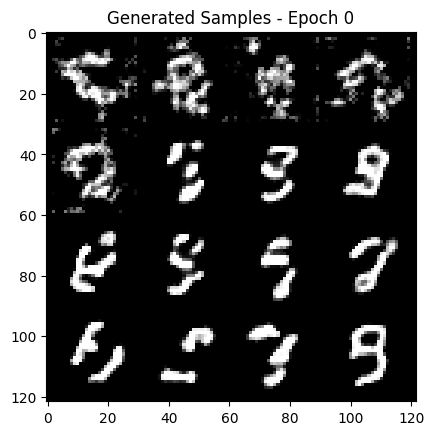

Epoch [1] Batch [0] Loss: 0.0094
Epoch [1] Batch [100] Loss: -0.0042
Epoch [1] Batch [200] Loss: 0.0037
Epoch [1] Batch [300] Loss: 0.0079
Epoch [1] Batch [400] Loss: -0.0028
Epoch [1] Batch [500] Loss: 0.0025
Epoch [1] Batch [600] Loss: 0.0067
Epoch [1] Batch [700] Loss: -0.0040
Epoch [1] Batch [800] Loss: -0.0023
Epoch [1] Batch [900] Loss: 0.0044

--- Epoch 1 Summary ---
Avg Real Energy: -0.0265
Avg Fake Energy: -0.0273
Avg Loss:        0.0008



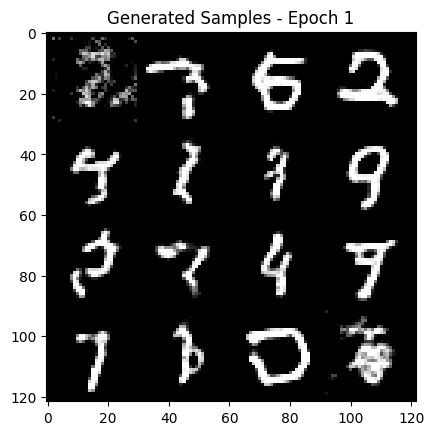

Epoch [2] Batch [0] Loss: -0.0033
Epoch [2] Batch [100] Loss: -0.0037
Epoch [2] Batch [200] Loss: -0.0003
Epoch [2] Batch [300] Loss: -0.0070
Epoch [2] Batch [400] Loss: -0.0064
Epoch [2] Batch [500] Loss: 0.0072
Epoch [2] Batch [600] Loss: -0.0020
Epoch [2] Batch [700] Loss: 0.0007
Epoch [2] Batch [800] Loss: -0.0056
Epoch [2] Batch [900] Loss: 0.0063

--- Epoch 2 Summary ---
Avg Real Energy: -0.0107
Avg Fake Energy: -0.0110
Avg Loss:        0.0004



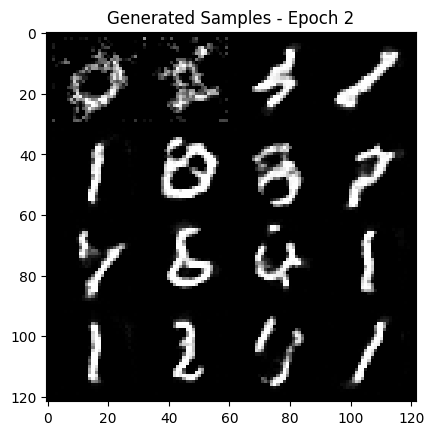

Epoch [3] Batch [0] Loss: -0.0089
Epoch [3] Batch [100] Loss: -0.0001
Epoch [3] Batch [200] Loss: -0.0003
Epoch [3] Batch [300] Loss: -0.0010
Epoch [3] Batch [400] Loss: 0.0001
Epoch [3] Batch [500] Loss: -0.0002
Epoch [3] Batch [600] Loss: -0.0016
Epoch [3] Batch [700] Loss: 0.0036
Epoch [3] Batch [800] Loss: -0.0035
Epoch [3] Batch [900] Loss: -0.0028

--- Epoch 3 Summary ---
Avg Real Energy: -0.0096
Avg Fake Energy: -0.0098
Avg Loss:        0.0002



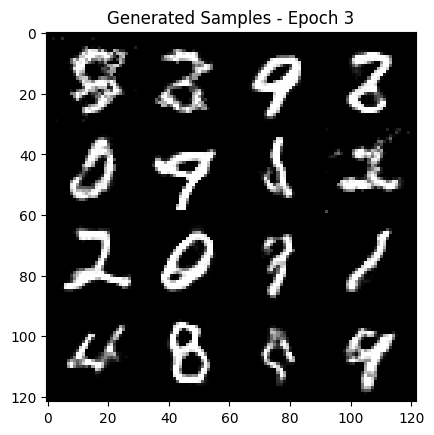

Epoch [4] Batch [0] Loss: 0.0066
Epoch [4] Batch [100] Loss: -0.0022
Epoch [4] Batch [200] Loss: 0.0024
Epoch [4] Batch [300] Loss: 0.0094
Epoch [4] Batch [400] Loss: -0.0007
Epoch [4] Batch [500] Loss: -0.0009
Epoch [4] Batch [600] Loss: 0.0077
Epoch [4] Batch [700] Loss: -0.0010
Epoch [4] Batch [800] Loss: -0.0054
Epoch [4] Batch [900] Loss: -0.0030

--- Epoch 4 Summary ---
Avg Real Energy: -0.0086
Avg Fake Energy: -0.0090
Avg Loss:        0.0004



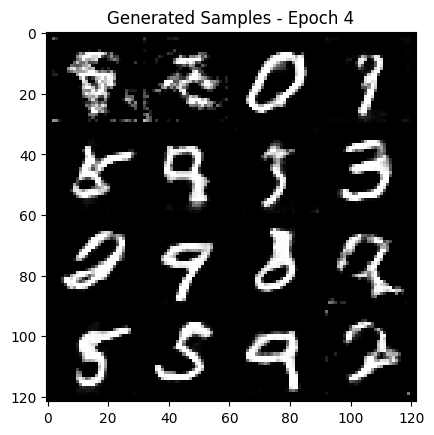

Epoch [5] Batch [0] Loss: 0.0106
Epoch [5] Batch [100] Loss: -0.0034
Epoch [5] Batch [200] Loss: 0.0016
Epoch [5] Batch [300] Loss: 0.0009
Epoch [5] Batch [400] Loss: -0.0004
Epoch [5] Batch [500] Loss: -0.0001
Epoch [5] Batch [600] Loss: -0.0029
Epoch [5] Batch [700] Loss: -0.0037
Epoch [5] Batch [800] Loss: 0.0069
Epoch [5] Batch [900] Loss: 0.0002

--- Epoch 5 Summary ---
Avg Real Energy: -0.0132
Avg Fake Energy: -0.0135
Avg Loss:        0.0004



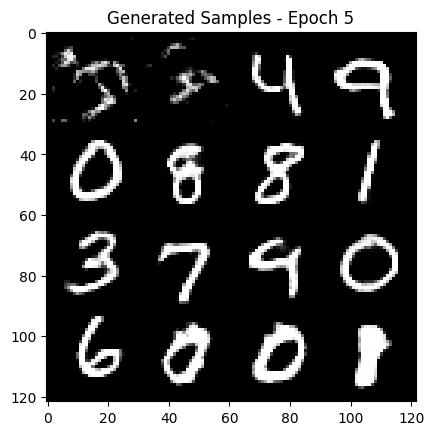

Epoch [6] Batch [0] Loss: -0.0053
Epoch [6] Batch [100] Loss: 0.0014
Epoch [6] Batch [200] Loss: 0.0021
Epoch [6] Batch [300] Loss: 0.0022
Epoch [6] Batch [400] Loss: 0.0042
Epoch [6] Batch [500] Loss: -0.0007
Epoch [6] Batch [600] Loss: 0.0084
Epoch [6] Batch [700] Loss: -0.0118
Epoch [6] Batch [800] Loss: 0.0222
Epoch [6] Batch [900] Loss: -0.0002

--- Epoch 6 Summary ---
Avg Real Energy: -0.0089
Avg Fake Energy: -0.0091
Avg Loss:        0.0003



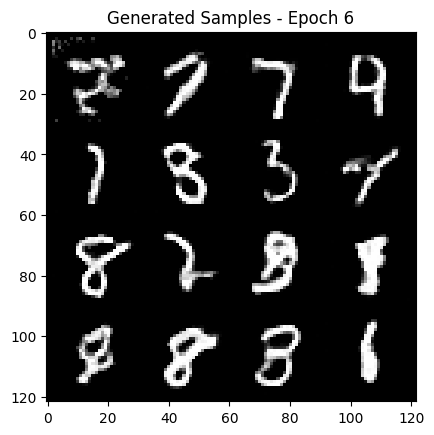

Epoch [7] Batch [0] Loss: 0.0070
Epoch [7] Batch [100] Loss: -0.0018
Epoch [7] Batch [200] Loss: 0.0039
Epoch [7] Batch [300] Loss: 0.0066
Epoch [7] Batch [400] Loss: 0.0133
Epoch [7] Batch [500] Loss: -0.0026
Epoch [7] Batch [600] Loss: -0.0032
Epoch [7] Batch [700] Loss: 0.0027
Epoch [7] Batch [800] Loss: 0.0039
Epoch [7] Batch [900] Loss: -0.0077

--- Epoch 7 Summary ---
Avg Real Energy: -0.0139
Avg Fake Energy: -0.0141
Avg Loss:        0.0002



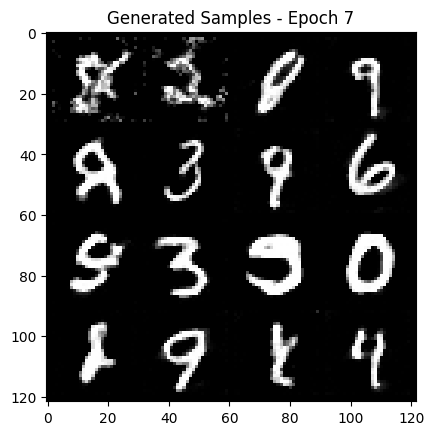

Epoch [8] Batch [0] Loss: -0.0032
Epoch [8] Batch [100] Loss: -0.0104
Epoch [8] Batch [200] Loss: 0.0018
Epoch [8] Batch [300] Loss: -0.0019
Epoch [8] Batch [400] Loss: 0.0010
Epoch [8] Batch [500] Loss: -0.0001
Epoch [8] Batch [600] Loss: 0.0107
Epoch [8] Batch [700] Loss: -0.0086
Epoch [8] Batch [800] Loss: -0.0034
Epoch [8] Batch [900] Loss: -0.0002

--- Epoch 8 Summary ---
Avg Real Energy: -0.0109
Avg Fake Energy: -0.0112
Avg Loss:        0.0003



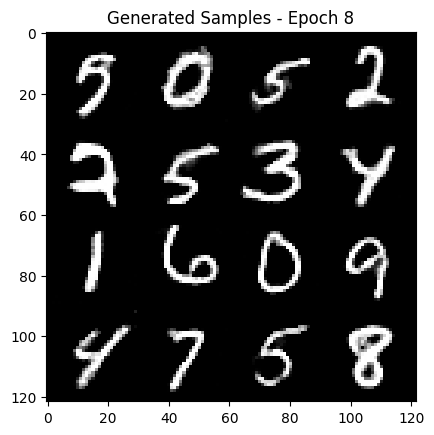

Epoch [9] Batch [0] Loss: -0.0052
Epoch [9] Batch [100] Loss: -0.0041
Epoch [9] Batch [200] Loss: -0.0020
Epoch [9] Batch [300] Loss: 0.0082
Epoch [9] Batch [400] Loss: -0.0014
Epoch [9] Batch [500] Loss: -0.0021
Epoch [9] Batch [600] Loss: -0.0021
Epoch [9] Batch [700] Loss: -0.0079
Epoch [9] Batch [800] Loss: -0.0002
Epoch [9] Batch [900] Loss: -0.0021

--- Epoch 9 Summary ---
Avg Real Energy: -0.0032
Avg Fake Energy: -0.0034
Avg Loss:        0.0003



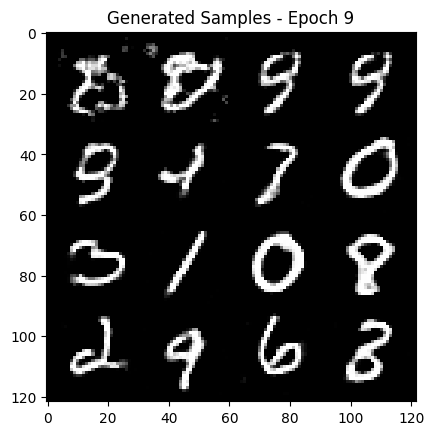

In [32]:
model = EnergyModel(hidden_features=HIDDEN_FEATURES).to(device)
sampler = SampleBuffer(model, image_shape=(28, 28), fake_images_size=BATCH_SIZE)
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(BETA1, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)

epoch_losses = []
epoch_real_energies = []
epoch_fake_energies = []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    running_loss = 0.0
    running_real_energy = 0.0
    running_fake_energy = 0.0
    batch_count = 0
    
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        
        current_batch_size = real_images.shape[0]
        
        sampler.fake_images_size = current_batch_size

        real_images.add_(torch.randn_like(real_images) * 0.005).clamp_(-1.0, 1.0)
        
        fake_images = sampler.generate_fake_images(steps=60, step_size=10.0)

        optimizer.zero_grad()

        energy_real = model(real_images)
        energy_fake = model(fake_images)

        loss_data = energy_real.mean() - energy_fake.mean()
        loss_reg = ALPHA * (energy_real**2 + energy_fake**2).mean()
        loss = loss_data + loss_reg

        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}] Batch [{i}] Loss: {loss.item():.4f}")
    
        running_loss += loss.item()
        running_real_energy += energy_real.mean().item()
        running_fake_energy += energy_fake.mean().item()
        batch_count += 1
        
    avg_loss = running_loss / batch_count
    avg_real = running_real_energy / batch_count
    avg_fake = running_fake_energy / batch_count
    
    epoch_losses.append(avg_loss)
    epoch_real_energies.append(avg_real)
    epoch_fake_energies.append(avg_fake)
    
    print(f"\n--- Epoch {epoch} Summary ---")
    print(f"Avg Real Energy: {avg_real:.4f}")
    print(f"Avg Fake Energy: {avg_fake:.4f}")
    print(f"Avg Loss:        {avg_loss:.4f}\n")
    
    scheduler.step()
    
    with torch.no_grad():
        sample_grid = torchvision.utils.make_grid(fake_images[:16], nrow=4, normalize=True)
        plt.imshow(sample_grid.cpu().permute(1, 2, 0))
        plt.title(f"Generated Samples - Epoch {epoch}")
        plt.show()

## Plots

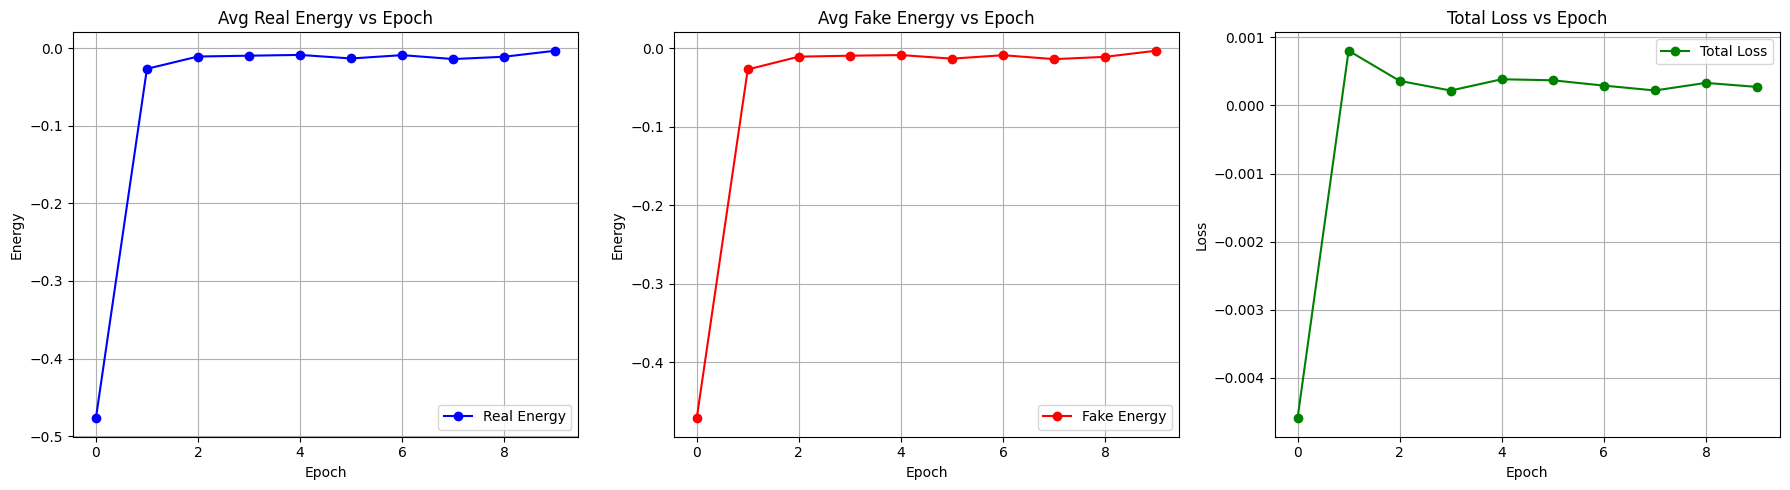

In [33]:
epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, epoch_real_energies, label='Real Energy', color='blue', marker='o')
plt.title('Avg Real Energy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Energy')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, epoch_fake_energies, label='Fake Energy', color='red', marker='o')
plt.title('Avg Fake Energy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Energy')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, epoch_losses, label='Total Loss', color='green', marker='o')
plt.title('Total Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Inference

# 1. Starting from training data and performing langevin sampling

each training data is treated as a real image therefore having a very low energy, so if the number of steps in langevin is too low (for example in the cell below is set to 60), then after sampling we'll see about the same image, **but** if we were to increase the number of cell, we can observe mode hopping.

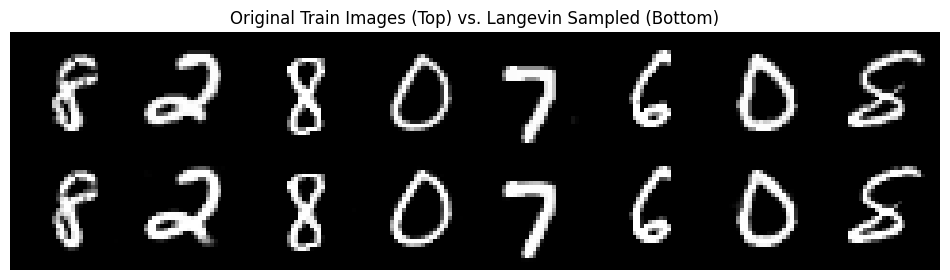

In [34]:
model.eval()

real_train_batch, _ = next(iter(train_loader))
real_train_batch = real_train_batch[:8].to(device) 


reconstructed_train = sampler.langevin_sampling(model, real_train_batch.clone(), steps=60, step_size=10.0)

def show_comparison(orig, gen, title):
    comparison = torch.cat([orig, gen], dim=0)
    grid = torchvision.utils.make_grid(comparison, nrow=8, normalize=True)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

show_comparison(real_train_batch, reconstructed_train, "Original Train Images (Top) vs. Langevin Sampled (Bottom)")

Increasing number of steps to 1000

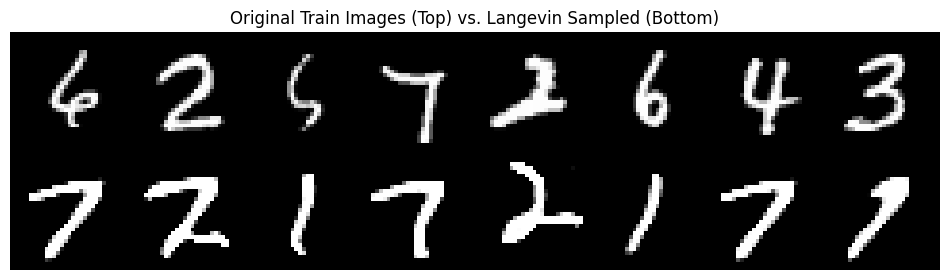

In [35]:
model.eval()

real_train_batch, _ = next(iter(train_loader))
real_train_batch = real_train_batch[:8].to(device) 


reconstructed_train = sampler.langevin_sampling(model, real_train_batch.clone(), steps=1000, step_size=100.0)

def show_comparison(orig, gen, title):
    comparison = torch.cat([orig, gen], dim=0)
    grid = torchvision.utils.make_grid(comparison, nrow=8, normalize=True)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

show_comparison(real_train_batch, reconstructed_train, "Original Train Images (Top) vs. Langevin Sampled (Bottom)")

# 2. Image Generation

    starting with pure noise and then performing langevin sampling
    the two cells below are for 200, 300 and 500 langevin steps, respectively.

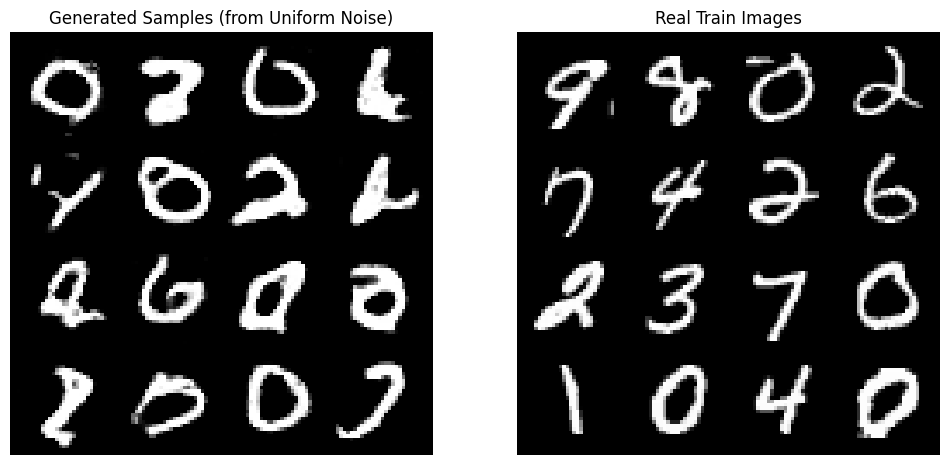

In [36]:
init_noise = (torch.rand((16, 1, 28, 28)) * 2 - 1).to(device) 

generated_images = sampler.langevin_sampling(model, init_noise, steps=200, step_size=10.0)

real_samples, _ = next(iter(train_loader))
real_samples = real_samples[:16].to(device)

def show_generation_results(gen, real):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    grid_gen = torchvision.utils.make_grid(gen, nrow=4, normalize=True)
    axes[0].imshow(grid_gen.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Generated Samples (from Uniform Noise)")
    axes[0].axis('off')
    
    grid_real = torchvision.utils.make_grid(real, nrow=4, normalize=True)
    axes[1].imshow(grid_real.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Real Train Images")
    axes[1].axis('off')
    
    plt.show()

show_generation_results(generated_images, real_samples)

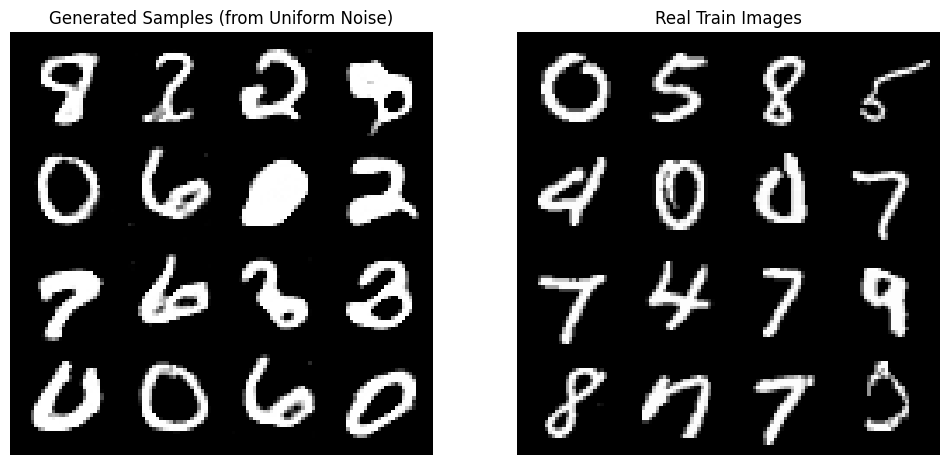

In [37]:
init_noise = (torch.rand((16, 1, 28, 28)) * 2 - 1).to(device) 

generated_images = sampler.langevin_sampling(model, init_noise, steps=300, step_size=10.0)

real_samples, _ = next(iter(train_loader))
real_samples = real_samples[:16].to(device)

def show_generation_results(gen, real):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    grid_gen = torchvision.utils.make_grid(gen, nrow=4, normalize=True)
    axes[0].imshow(grid_gen.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Generated Samples (from Uniform Noise)")
    axes[0].axis('off')
    
    grid_real = torchvision.utils.make_grid(real, nrow=4, normalize=True)
    axes[1].imshow(grid_real.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Real Train Images")
    axes[1].axis('off')
    
    plt.show()

show_generation_results(generated_images, real_samples)

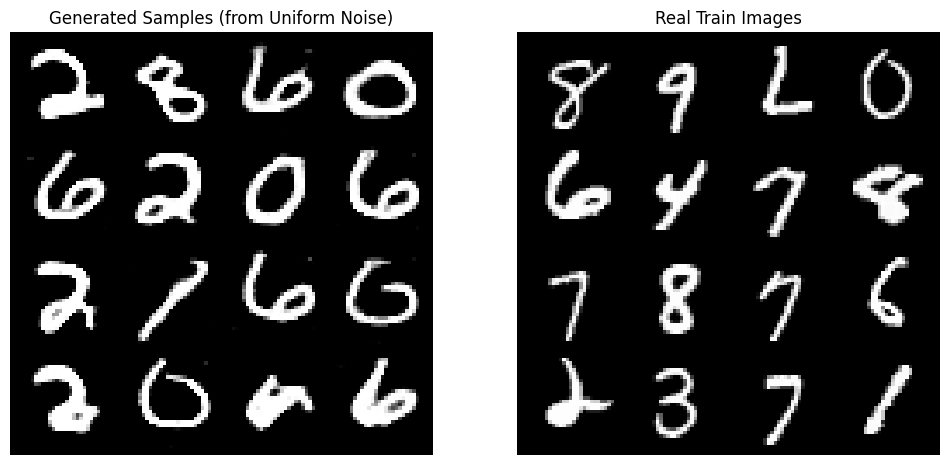

In [38]:
init_noise = (torch.rand((16, 1, 28, 28)) * 2 - 1).to(device) 

generated_images = sampler.langevin_sampling(model, init_noise, steps=500, step_size=10.0)

real_samples, _ = next(iter(train_loader))
real_samples = real_samples[:16].to(device)

def show_generation_results(gen, real):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    grid_gen = torchvision.utils.make_grid(gen, nrow=4, normalize=True)
    axes[0].imshow(grid_gen.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Generated Samples (from Uniform Noise)")
    axes[0].axis('off')
    
    grid_real = torchvision.utils.make_grid(real, nrow=4, normalize=True)
    axes[1].imshow(grid_real.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Real Train Images")
    axes[1].axis('off')
    
    plt.show()

show_generation_results(generated_images, real_samples)

# 3. Denoising

The two cells below are for 100 and 1000 langevin steps respectively.

Results for Noise Level (Sigma): 0.2


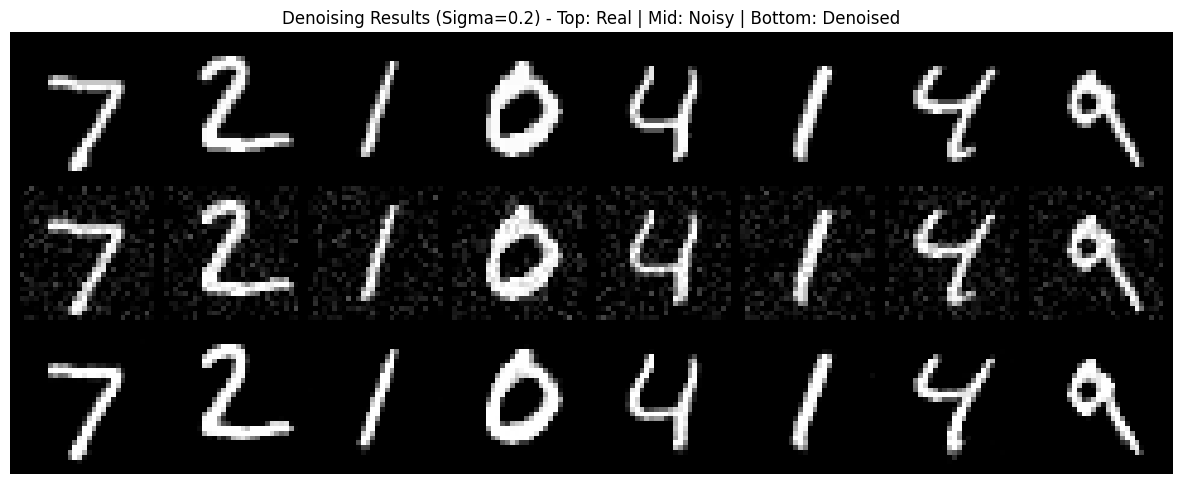

Results for Noise Level (Sigma): 0.4


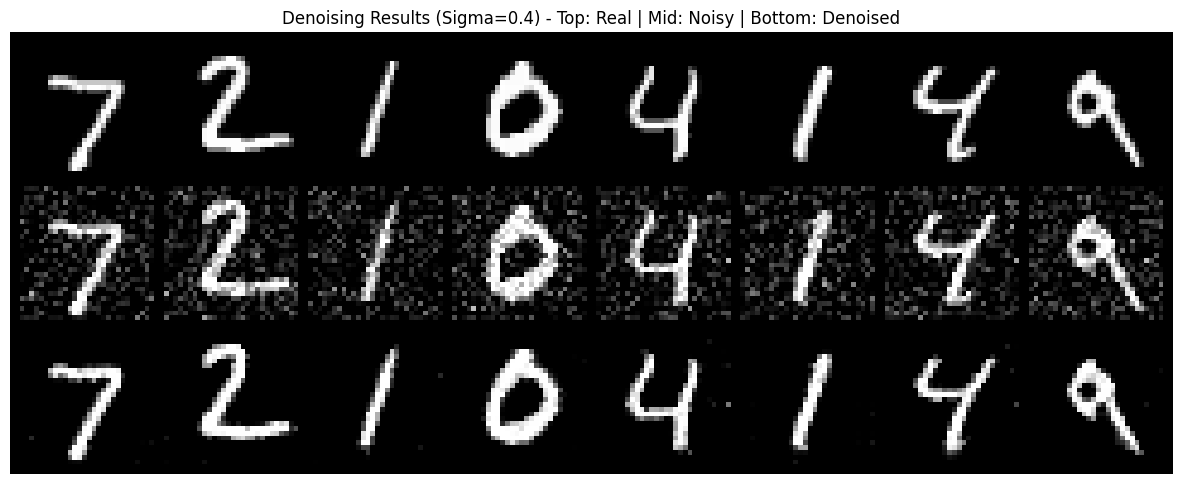

Results for Noise Level (Sigma): 0.6


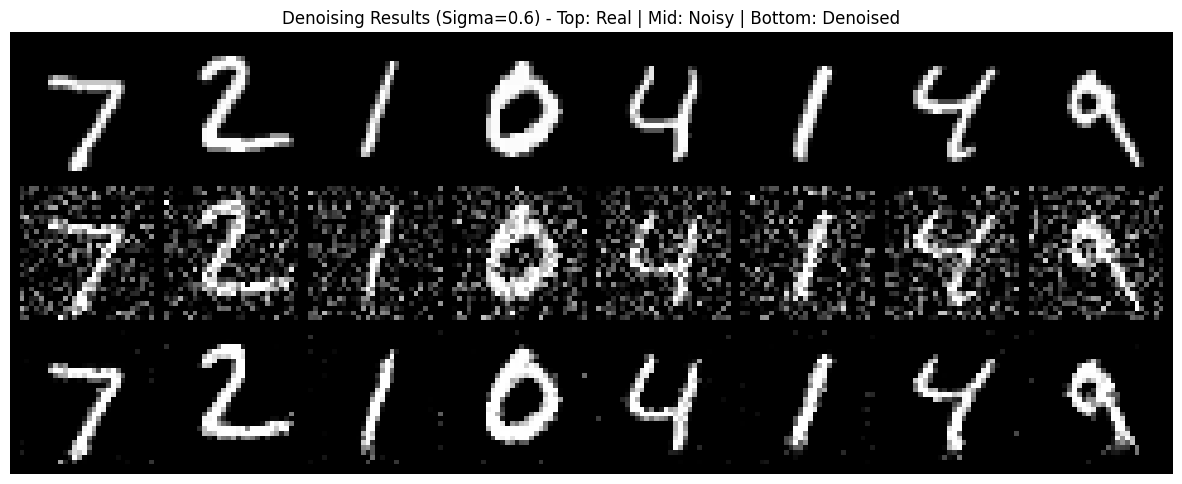

In [39]:
test_batch, _ = next(iter(test_loader))
test_batch = test_batch[:16].to(device)

noise_levels = [0.2, 0.4, 0.6]

for sigma in noise_levels:
    noisy_images = test_batch + sigma * torch.randn_like(test_batch)
    
    noisy_images = torch.clamp(noisy_images, -1, 1)
    
    denoised_images = sampler.langevin_sampling(model, noisy_images.clone(), steps=100, step_size=10.0)
    
    print(f"Results for Noise Level (Sigma): {sigma}")
    
    combined = torch.cat([test_batch[:8], noisy_images[:8], denoised_images[:8]], dim=0)
    grid = torchvision.utils.make_grid(combined, nrow=8, normalize=True)
    
    plt.figure(figsize=(15, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Denoising Results (Sigma={sigma}) - Top: Real | Mid: Noisy | Bottom: Denoised")
    plt.axis('off')
    plt.show()

Results for Noise Level (Sigma): 0.2


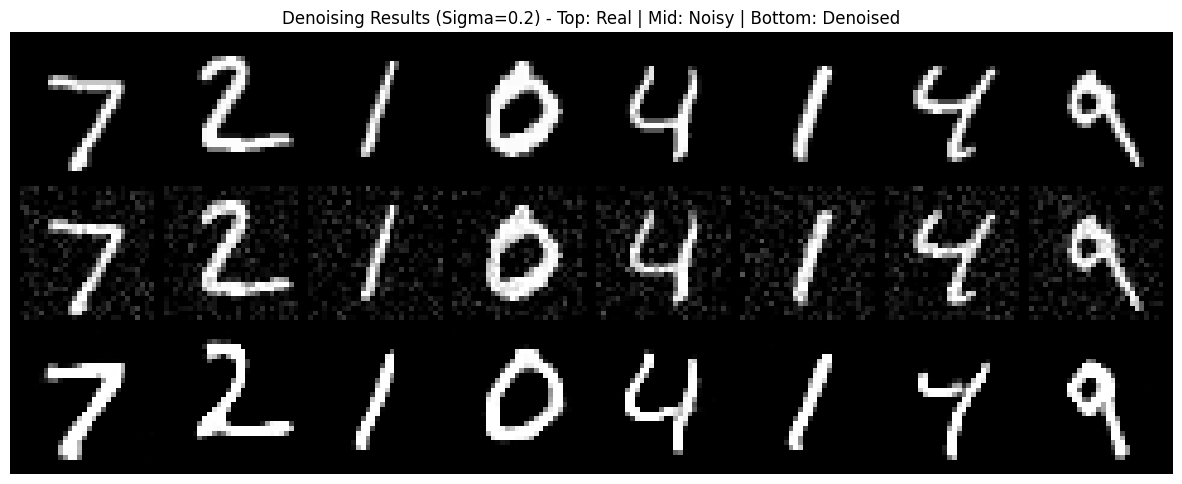

Results for Noise Level (Sigma): 0.4


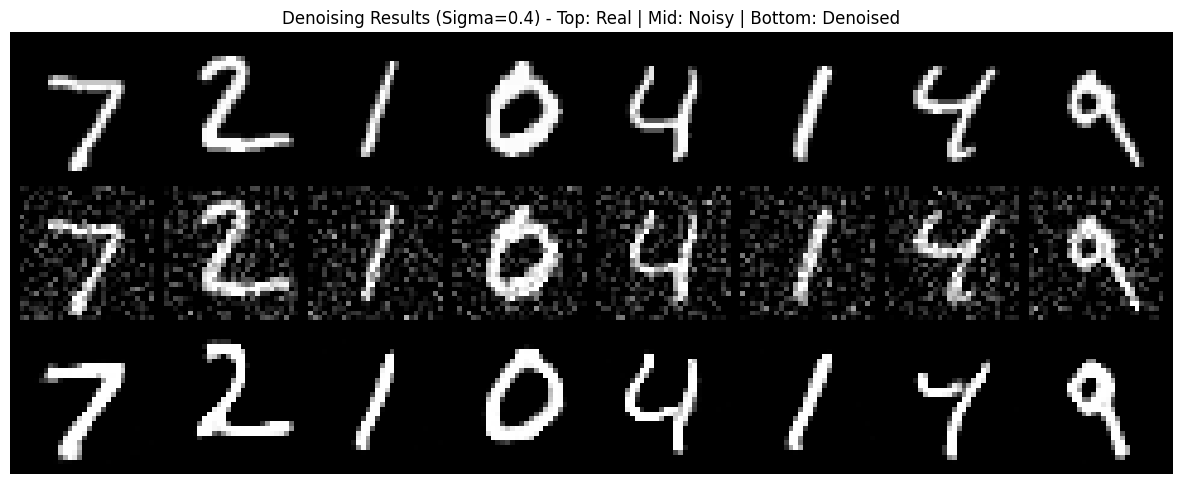

Results for Noise Level (Sigma): 0.6


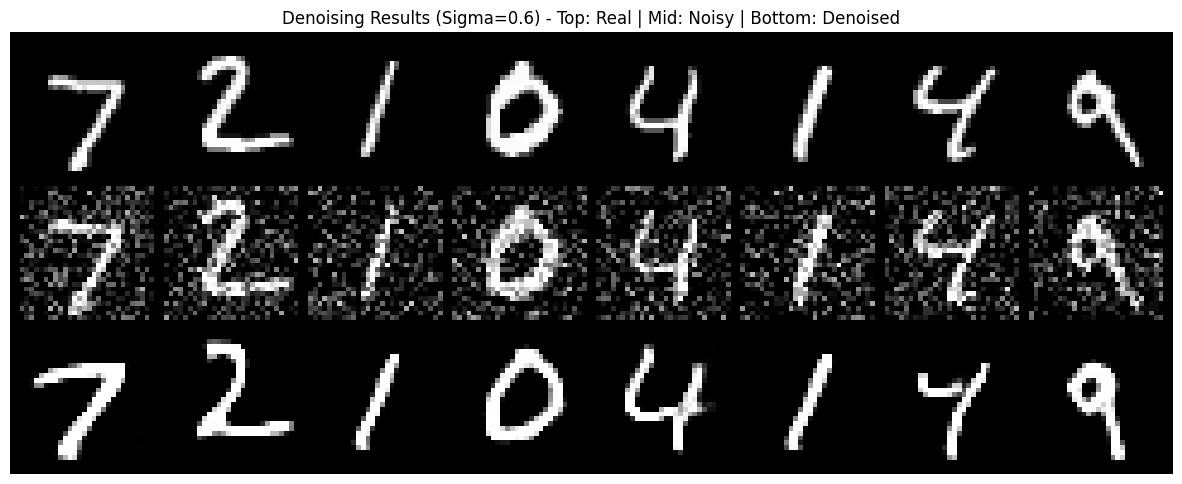

In [40]:
test_batch, _ = next(iter(test_loader))
test_batch = test_batch[:16].to(device)

noise_levels = [0.2, 0.4, 0.6]

for sigma in noise_levels:
    noisy_images = test_batch + sigma * torch.randn_like(test_batch)
    
    noisy_images = torch.clamp(noisy_images, -1, 1)
    
    denoised_images = sampler.langevin_sampling(model, noisy_images.clone(), steps=1000, step_size=10.0)
    
    print(f"Results for Noise Level (Sigma): {sigma}")
    
    combined = torch.cat([test_batch[:8], noisy_images[:8], denoised_images[:8]], dim=0)
    grid = torchvision.utils.make_grid(combined, nrow=8, normalize=True)
    
    plt.figure(figsize=(15, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Denoising Results (Sigma={sigma}) - Top: Real | Mid: Noisy | Bottom: Denoised")
    plt.axis('off')
    plt.show()